In [117]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2025-01-29 13:34:41.356010: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-29 13:34:41.472163: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-29 13:34:41.887111: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-29 13:34:41.889644: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-29 13:34:42.797125: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [118]:
# 1. CONFIGURE PATHS
DATA_PATH = "../AI-CPS/data/joint_data_collection.csv"
OUTPUT_DIR = "./learningBase"  # We'll store all output here

MODEL_FILENAME = "currentAiSolution.h5"  # or .xml, etc.
TRAIN_LOG_FILENAME = "training_log.csv"
METRICS_FILENAME = "final_metrics.txt"
TRAINING_CURVE_FILENAME = "training_curve.png"
CONF_MATRIX_FILENAME = "confusion_matrix.png"

os.makedirs(OUTPUT_DIR, exist_ok=True)

In [119]:
# 2. LOAD DATA
df = pd.read_csv(DATA_PATH)
# We assume columns are "tweet" and "sarcastic" with 1 = sarcasm, 0 = not sarcasm

tweets = df["tweet"].astype(str).values
labels = df["sarcastic"].astype(int).values

# 3. SPLIT DATA INTO TRAIN & TEST
X_train, X_test, y_train, y_test = train_test_split(
    tweets, labels, test_size=0.2, random_state=42
)

# 4. BASIC TEXT PREPROCESSING WITH TF KERAS (TextVectorization)
# You can adjust max_tokens, sequence_length, etc.
max_tokens = 10000
max_length = 50  # Maximum number of tokens per tweet

vectorizer = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length
)
# "Fit" the vectorizer on the training text only
vectorizer.adapt(X_train)

2025-01-29 13:35:01.109222: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-29 13:35:01.112738: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [146]:
y_train

array([0, 0, 0, ..., 0, 1, 0])

In [140]:
# 5. BUILD A SIMPLE MODEL
# Example: Embedding + GlobalAveragePooling + Dense
model = keras.Sequential([
    vectorizer,
    layers.Embedding(input_dim=max_tokens, output_dim=64, mask_zero=True),
    layers.GlobalAveragePooling1D(),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 50)               0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, 50, 64)            640000    
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 256)               16640     
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 1)                

In [145]:
# 6. TRAIN THE MODEL
EPOCHS = 5
BATCH_SIZE = 40

history = model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,  # Some validation split out of the training set
    verbose=1
)

Epoch 1/5
56/56 [==============================] - 0s 5ms/step - loss: 0.0017 - accuracy: 0.9991 - val_loss: 3.2580 - val_accuracy: 0.6559
Epoch 2/5
56/56 [==============================] - 0s 5ms/step - loss: 0.0017 - accuracy: 0.9991 - val_loss: 3.2643 - val_accuracy: 0.6559
Epoch 3/5
56/56 [==============================] - 0s 5ms/step - loss: 0.0017 - accuracy: 0.9991 - val_loss: 3.2706 - val_accuracy: 0.6559
Epoch 4/5
56/56 [==============================] - 0s 4ms/step - loss: 0.0017 - accuracy: 0.9991 - val_loss: 3.2770 - val_accuracy: 0.6559
Epoch 5/5
56/56 [==============================] - 0s 4ms/step - loss: 0.0017 - accuracy: 0.9991 - val_loss: 3.2833 - val_accuracy: 0.6559


In [122]:
# 7. SAVE TRAINING LOG (loss, accuracy per epoch) to CSV
log_dict = {
    "epoch": list(range(1, EPOCHS+1)),
    "loss": history.history['loss'],
    "val_loss": history.history['val_loss'],
    "accuracy": history.history['accuracy'],
    "val_accuracy": history.history['val_accuracy']
}
log_df = pd.DataFrame(log_dict)
log_df.to_csv(os.path.join(OUTPUT_DIR, TRAIN_LOG_FILENAME), index=False)

In [123]:
# 8. FINAL EVALUATION ON TEST SET
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
y_pred_prob = model.predict(X_test).ravel()
y_pred = (y_pred_prob >= 0.5).astype(int)

22/22 [==============================] - 0s 523us/step


In [124]:
# 9. SAVE FINAL METRICS
report = classification_report(y_test, y_pred, digits=4)
with open(os.path.join(OUTPUT_DIR, METRICS_FILENAME), 'w') as f:
    f.write(f"Test Loss: {test_loss}\n")
    f.write(f"Test Accuracy: {test_acc}\n")
    f.write("\nClassification Report:\n")
    f.write(report)

In [138]:
!ls ../AI-CPS/code/

housing_data.csv  scraping_and_preparation.ipynb  tf_model_1.keras
model.ipynb	  tf_model_1.h5


In [139]:
model.save("tf_model_1.h5")

NotImplementedError: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Received a model or layer TextVectorization with weights [<keras.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x7efc49052c80>]

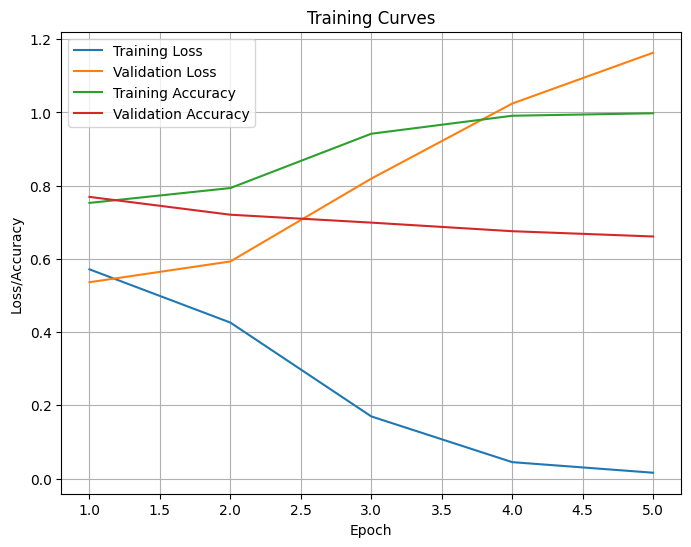

In [127]:
# 11. PLOT TRAINING CURVES
plt.figure(figsize=(8,6))
plt.plot(log_dict["epoch"], log_dict["loss"], label="Training Loss")
plt.plot(log_dict["epoch"], log_dict["val_loss"], label="Validation Loss")
plt.plot(log_dict["epoch"], log_dict["accuracy"], label="Training Accuracy")
plt.plot(log_dict["epoch"], log_dict["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.title("Training Curves")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(OUTPUT_DIR, TRAINING_CURVE_FILENAME))
plt.show()


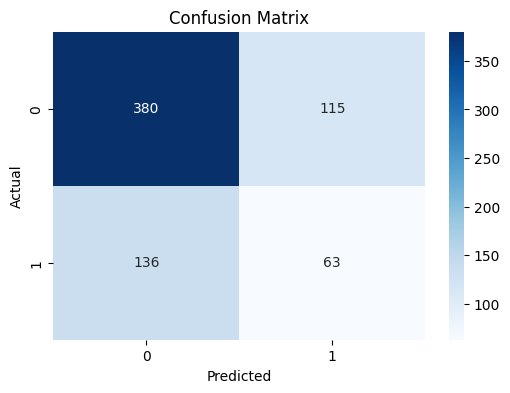

In [128]:
# 12. PLOT CONFUSION MATRIX
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig(os.path.join(OUTPUT_DIR, CONF_MATRIX_FILENAME))
plt.show()